# CIFAR10 Dataset (10 image categories)

Attempts to build a state-of-the-art model. Benchmarks can be found at https://paperswithcode.com/sota/image-classification-on-cifar-10

In [79]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Setup

### Get the data

In [54]:
# Transform images to tensors and normalize when loaded
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) # mean of 0.5 for each channel, sd of 0.5 for each channel
])

# Set the batch size
batch_size = 16

# Create the train and test dataloaders
train_set = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

# Create the class labels
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 32, 32])


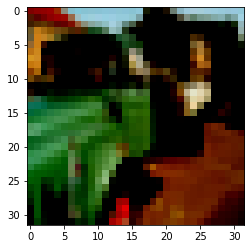

In [102]:
example_image = next(iter(train_loader))[0][0]
print(example_image.shape)
np_image = example_image.numpy()
plt.imshow(np.transpose(np_image, (1, 2, 0)))

### Train & Test Loops

Creates train & test loops that can be used with different models.

In [81]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train(
    model: nn.Module, 
    loss_function, 
    learning_rate: float = 0.001, 
    epochs: int = 4) -> nn.Module:
    """
    Train the model
    
    Parameters
    ----------
    model : Model
    loss_function: Loss function (e.g. `nn.CrossEntropyLoss()`)
    learning_rate: Learning rate
    epochs: Number of epochs

    Returns
    -------
    float: Accurancy
    """
    start_time = time.time()
    
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    
    # For each epoch
    for epoch in range(epochs):
        
         # Set a running loss
        running_loss = 0.

        # Go through each batch
        for data in train_loader:
            # Each batch contains [inputs, labels]
            inputs = data[0].to(device)
            labels = data[1].to(device)

            # Reset the model parameter gradients to 0
            optimizer.zero_grad()

            # Forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Backward
            loss.backward()
            optimizer.step()

        # Print statistics
        time_taken = time.time() - start_time
        print('Epoch %d, loss %.3f, time %.3f' % (epoch + 1, running_loss, time_taken))

In [80]:
def test(model: nn.Module) -> float:
    """
    Check the model accuracy with the test data

    Returns
    -------
    float: Accuracy
    """
    
    # Initialise counters
    predictions_count = 0
    correct_count = 0
    
    # For each batch
    for data in test_loader:
        inputs = data[0].to(device)
        labels = data[1].to(device)
        
        # Get the predictions
        outputs = model(inputs)
        predictions = outputs.argmax(1)
        correct = predictions == labels
        
        # Increment the counters
        predictions_count += correct.shape[0]
        correct_count += correct.type(torch.float).sum().item()
        
    # Return the accuracy percentage
    accuracy = correct_count/predictions_count
    return accuracy

## Baseline CNN

Taken from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-on-gpu

Note accuracy appears to make most of the gains by epoch 4 in previous testing.

In [103]:
class BaseLineCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5) # Flatten each image to a vector
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
baseline = BaseLineCNN()
baseline.to(device)
criterion = nn.CrossEntropyLoss()
train(baseline, criterion)

print("\nAccuracy:")
test(baseline)

Epoch 1, loss 5633.576, time 7.763
Epoch 2, loss 4813.185, time 15.781
Epoch 3, loss 4483.288, time 23.595
Epoch 4, loss 4248.014, time 31.441

Accuracy:


0.5043

## Vanilla MLP

In [105]:
class VanillaMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3) # Flatten each image to a vector
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
vanilla = VanillaMLP()
vanilla.to(device)
criterion = nn.CrossEntropyLoss()
train(vanilla, criterion)

print("\nAccuracy:")
test(vanilla)

Epoch 1, loss 5670.843, time 8.275
Epoch 2, loss 4828.096, time 16.888
Epoch 3, loss 4496.578, time 25.391
Epoch 4, loss 4268.337, time 34.045

Accuracy:


0.4992